In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

214

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
is_denso = False
train_path = '/home/hayato/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
if is_denso:
    train_path = '/home/denso/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'

# train dataを10万に絞る
train_data = pd.read_csv(train_path, encoding='utf-8')
train_data = train_data[:100000]
train_data_for_ranking = train_data.copy()
print("train data length {}".format(len(train_data)))

train data length 100000


In [5]:
inference_page_id = 2024060508

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [6]:
train_data


,Unnamed: 0,target_no1_umaban,date,race_name,place,class_list_in_race,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds,goal_number
0,0,5,253,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",シゲルダイノウカイ,1,2,0,462,4,54.0,小原義之,7.0,2
1,1,5,253,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",スイートゴールド,2,2,1,-14,-14,53.0,藤岡佑介,81.6,10
2,2,5,253,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",スズカイエロー,3,2,0,500,-2,54.0,蛯名正義,2.3,6
3,3,5,253,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",インザリピート,4,2,1,448,-8,54.0,松永幹夫,74.4,8
4,4,5,253,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",テイエムヒスイ,5,2,1,432,-18,54.0,秋山真一,3.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,940,3歳以上500万下,",1回函館5日目",",3歳以上500万下",12,1000,",ダ",ティムガッド,6,3,0,468,2,54.0,津村明秀,5.5,7
99996,99996,1,940,3歳以上500万下,",1回函館5日目",",3歳以上500万下",12,1000,",ダ",クィーンマルトク,7,5,1,464,4,55.0,小林徹弥,5.7,5
99997,99997,1,940,3歳以上500万下,",1回函館5日目",",3歳以上500万下",12,1000,",ダ",ムソウ,8,6,1,468,-4,52.0,黛弘人,90.8,6
99998,99998,1,940,3歳以上500万下,",1回函館5日目",",3歳以上500万下",12,1000,",ダ",ガールズポップ,9,3,1,466,4,52.0,藤田伸二,2.2,3


In [7]:
train_data.describe()

,Unnamed: 0,target_no1_umaban,date,number_of_horses,distance,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,odds,goal_number
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,49999.500000,7.652610,411.193050,14.512540,1622.117600,7.756170,3.691050,0.430750,468.159830,0.14410,55.096190,70.591099,7.756190
std,28867.657797,4.366937,228.209908,2.332059,444.493163,4.390992,1.336547,0.561896,38.304511,6.80471,1.799718,102.849985,4.391002
min,0.000000,1.000000,35.000000,4.000000,1000.000000,1.000000,2.000000,0.000000,-26.000000,-46.00000,48.000000,1.000000,1.000000
25%,24999.750000,4.000000,219.000000,13.000000,1200.000000,4.000000,3.000000,0.000000,450.000000,-4.00000,54.000000,8.700000,4.000000
50%,49999.500000,7.000000,410.000000,15.000000,1600.000000,8.000000,3.000000,0.000000,468.000000,0.00000,55.000000,26.900000,8.000000
75%,74999.250000,11.000000,591.000000,16.000000,1800.000000,11.000000,4.000000,1.000000,488.000000,4.00000,56.000000,87.700000,11.000000
max,99999.000000,18.000000,1030.000000,18.000000,4250.000000,18.000000,13.000000,2.000000,608.000000,60.00000,66.000000,999.900000,18.000000


In [8]:
# 前処理
def preprocess(train_data, is_ranking=False):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    train_data = train_data.drop(['Unnamed: 0','target_no1_umaban', 'class_list_in_race',"date"], axis=1)
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない
    if not is_ranking:
        # ランキング学習でない場合は通常のグルーピング
        # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
        train_data['goal_number'] = train_data['goal_number'].replace(
            {1: 0, 2: 1, 3: 1}
        ).apply(lambda x: 2 if x >= 4 else x)
    else:
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # goal numberをスコア化
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        train_data['goal_number_replace'] = train_data['goal_number'].apply(
            lambda x: 30 if x == 1 else (28 if x == 2 else (26 if x == 3 else 0)))
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    train_data.columns = train_data.columns.str.replace(":", "_")
    train_data.columns = train_data.columns.str.replace(",", "_")
    train_data.columns = train_data.columns.str.replace("'", "_")
    train_data.columns = train_data.columns.str.replace('"', "_")
    train_data.columns = train_data.columns.str.replace(" ", "_")
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    # if not is_ranking:
    #     train_data = train_data[:50000]
    return train_data

train_data = preprocess(train_data)

In [9]:
train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   race_name         100000 non-null  int64  
 1   place             100000 non-null  int64  
 2   number_of_horses  100000 non-null  int64  
 3   distance          100000 non-null  int64  
 4   condition         100000 non-null  int64  
 5   horse_name_       100000 non-null  int64  
 6   umaban            100000 non-null  int64  
 7   horse_age         100000 non-null  int64  
 8   horse_sex         100000 non-null  int64  
 9   horse_weight      100000 non-null  int64  
 10  weight_change     100000 non-null  int64  
 11  handi             100000 non-null  float64
 12  jocky             100000 non-null  int64  
 13  odds              100000 non-null  float64
 14  goal_number       100000 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 11.4 MB


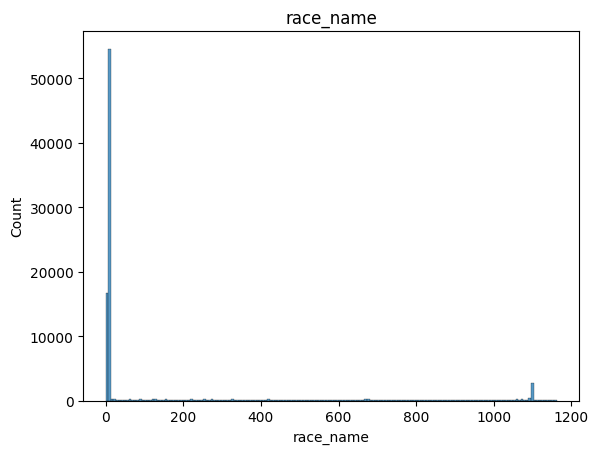

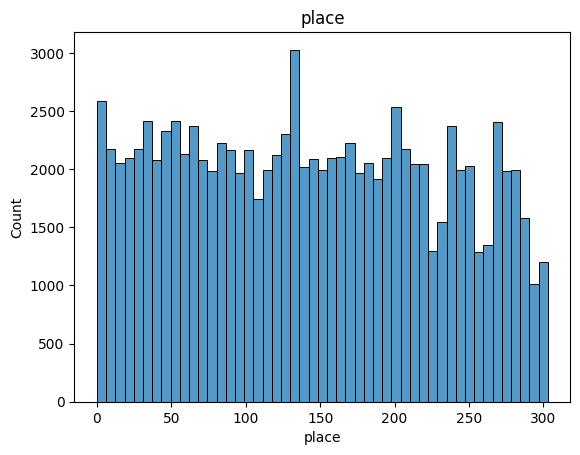

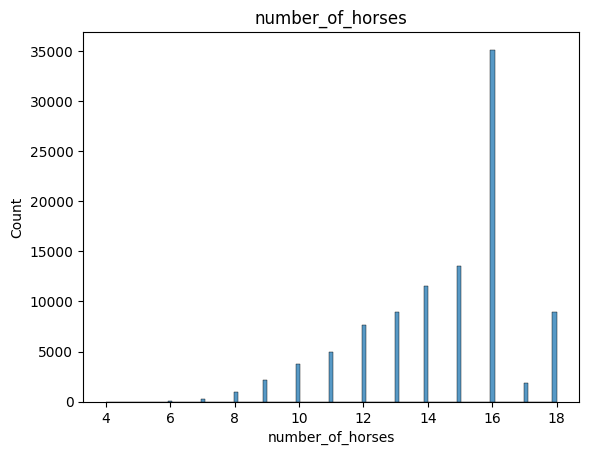

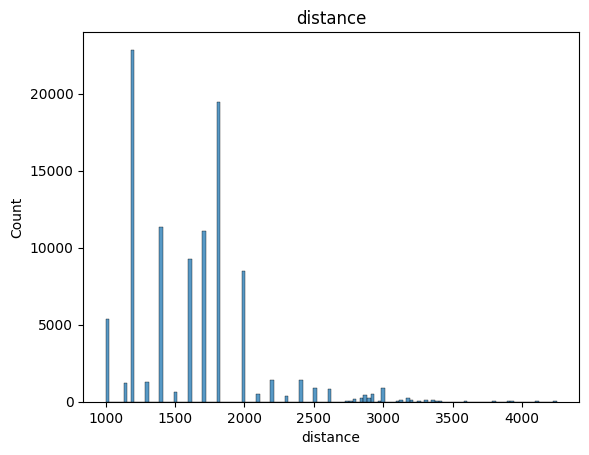

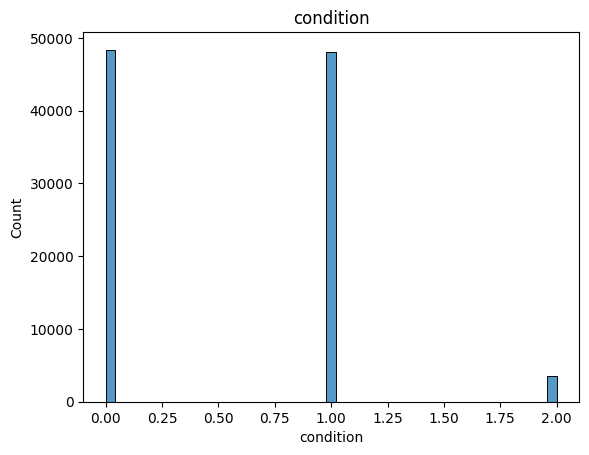

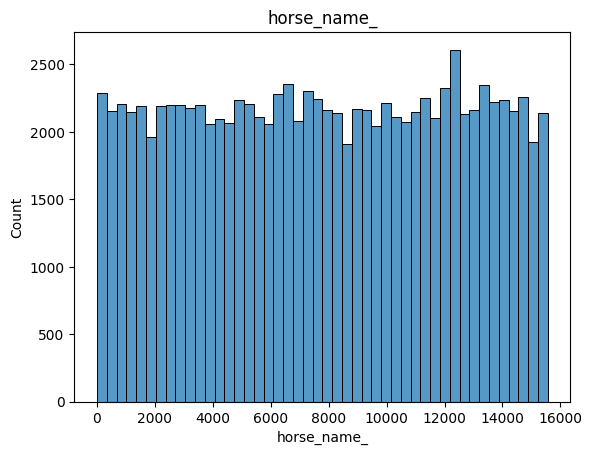

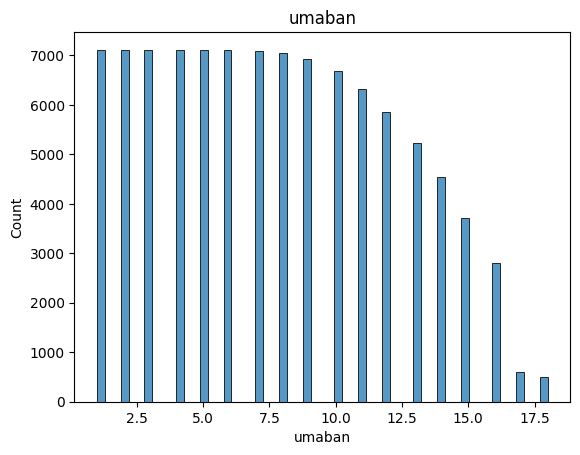

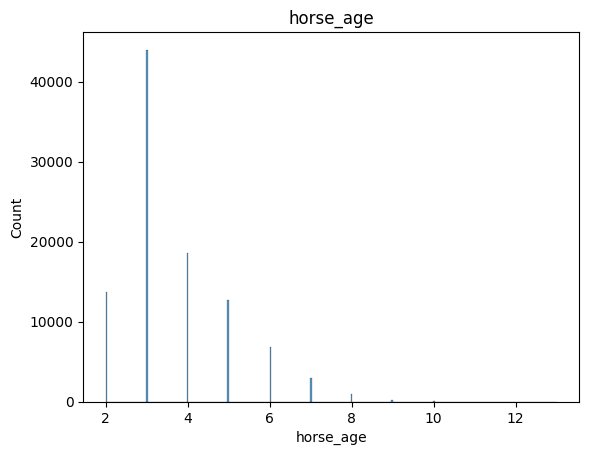

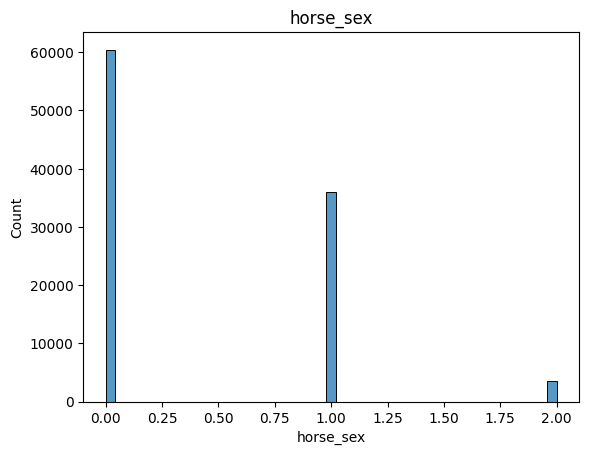

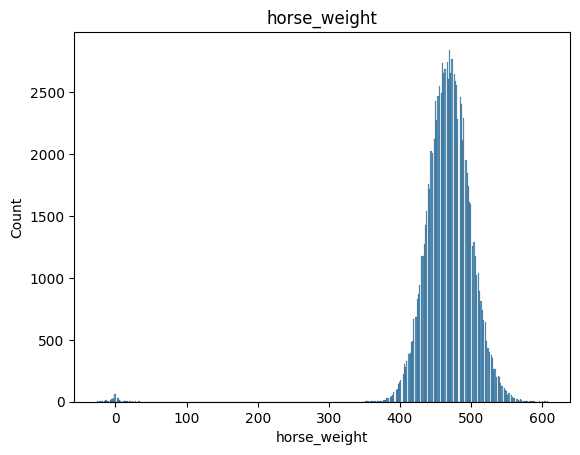

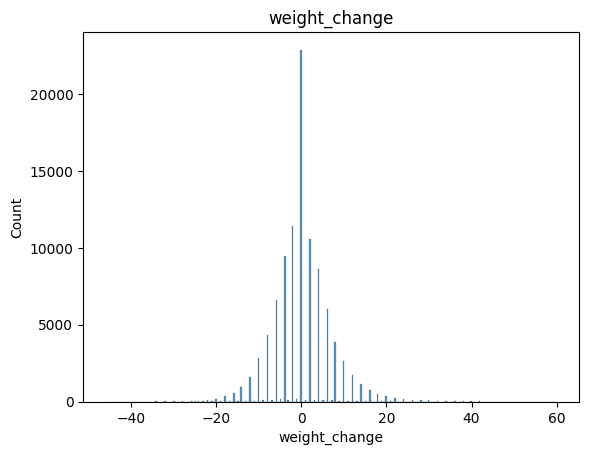

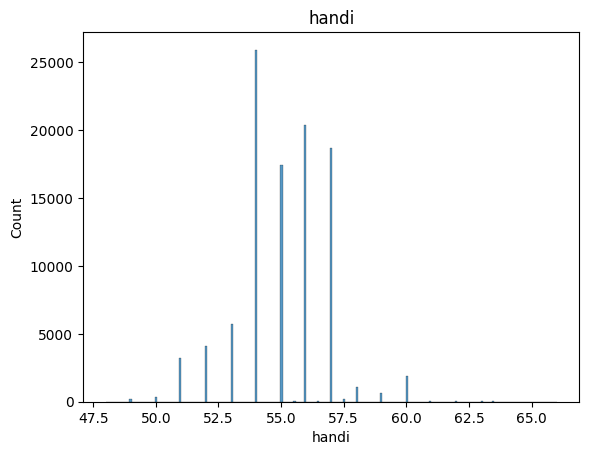

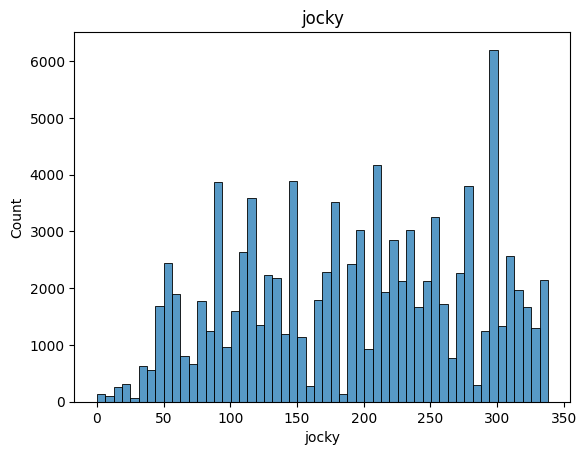

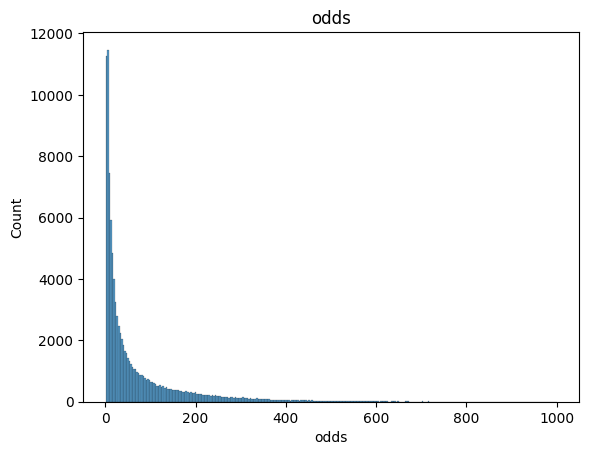

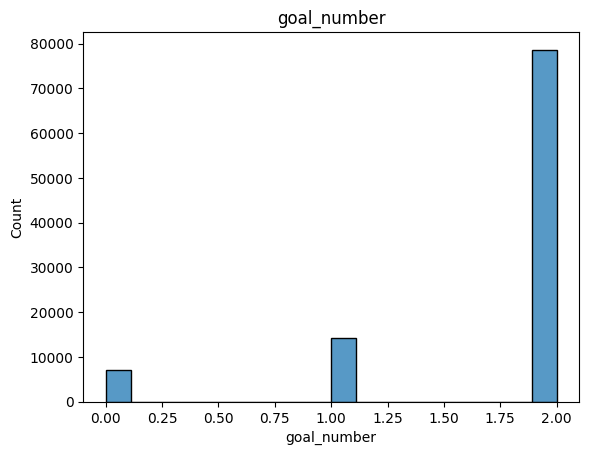

In [10]:
# train_dataの特長量のヒストグラムを表示する
features = train_data.columns
for feature in features:
    plt.figure()
    sns.histplot(train_data[feature])
    plt.title(feature)
    plt.show()


In [11]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [12]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [13]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 56000
valid data length 14000
test data length 30000
train data length 56000
valid data length 14000
test data length 30000


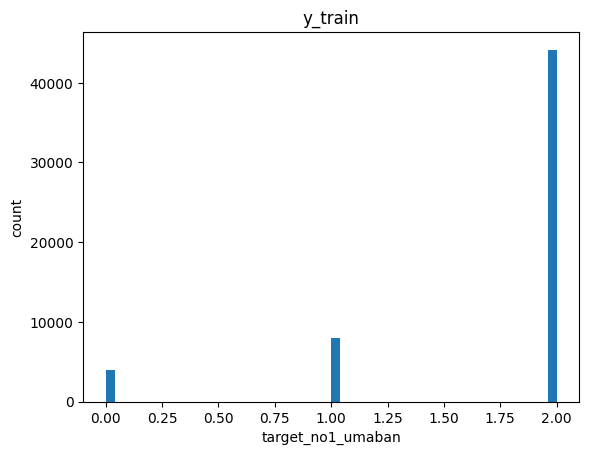

6294     2
92062    2
79348    2
96589    2
47180    1
        ..
21902    0
42062    2
31949    2
6963     1
60253    1
Name: goal_number, Length: 56000, dtype: int64


In [15]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [16]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[0.42280105 0.42280105 0.42280105 ... 0.42280105 2.3569024  2.3569024 ]
[1. 1. 1. ... 1. 1. 1.]


In [17]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [18]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":100, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [19]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 100,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -2.656712
[LightGBM] [Info] Start training from score -1.955960
[LightGBM] [Info] Start training from score -0.237759
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.539041	valid's multi_logloss: 0.540776


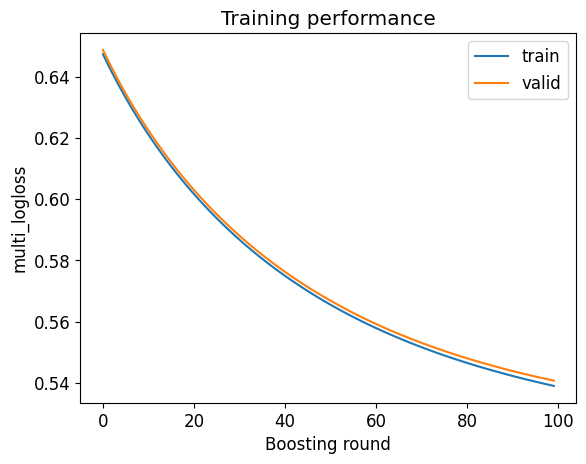

In [20]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [21]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.090898  0.217714  0.691388
1  0.082523  0.190905  0.726572
2  0.022797  0.047045  0.930158
3  0.022797  0.047045  0.930158
4  0.029104  0.074422  0.896474
0        0.090898
1        0.082523
2        0.022797
3        0.022797
4        0.029104
           ...   
13995    0.086097
13996    0.023347
13997    0.274145
13998    0.022797
13999    0.031700
Name: 0, Length: 14000, dtype: float64


In [22]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0        2
1        2
2        2
3        2
4        2
        ..
13995    2
13996    2
13997    2
13998    2
13999    2
Length: 14000, dtype: int64

In [23]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

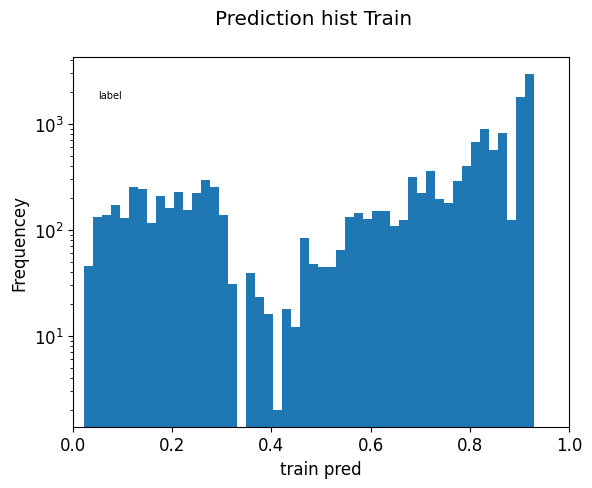

In [24]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [25]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

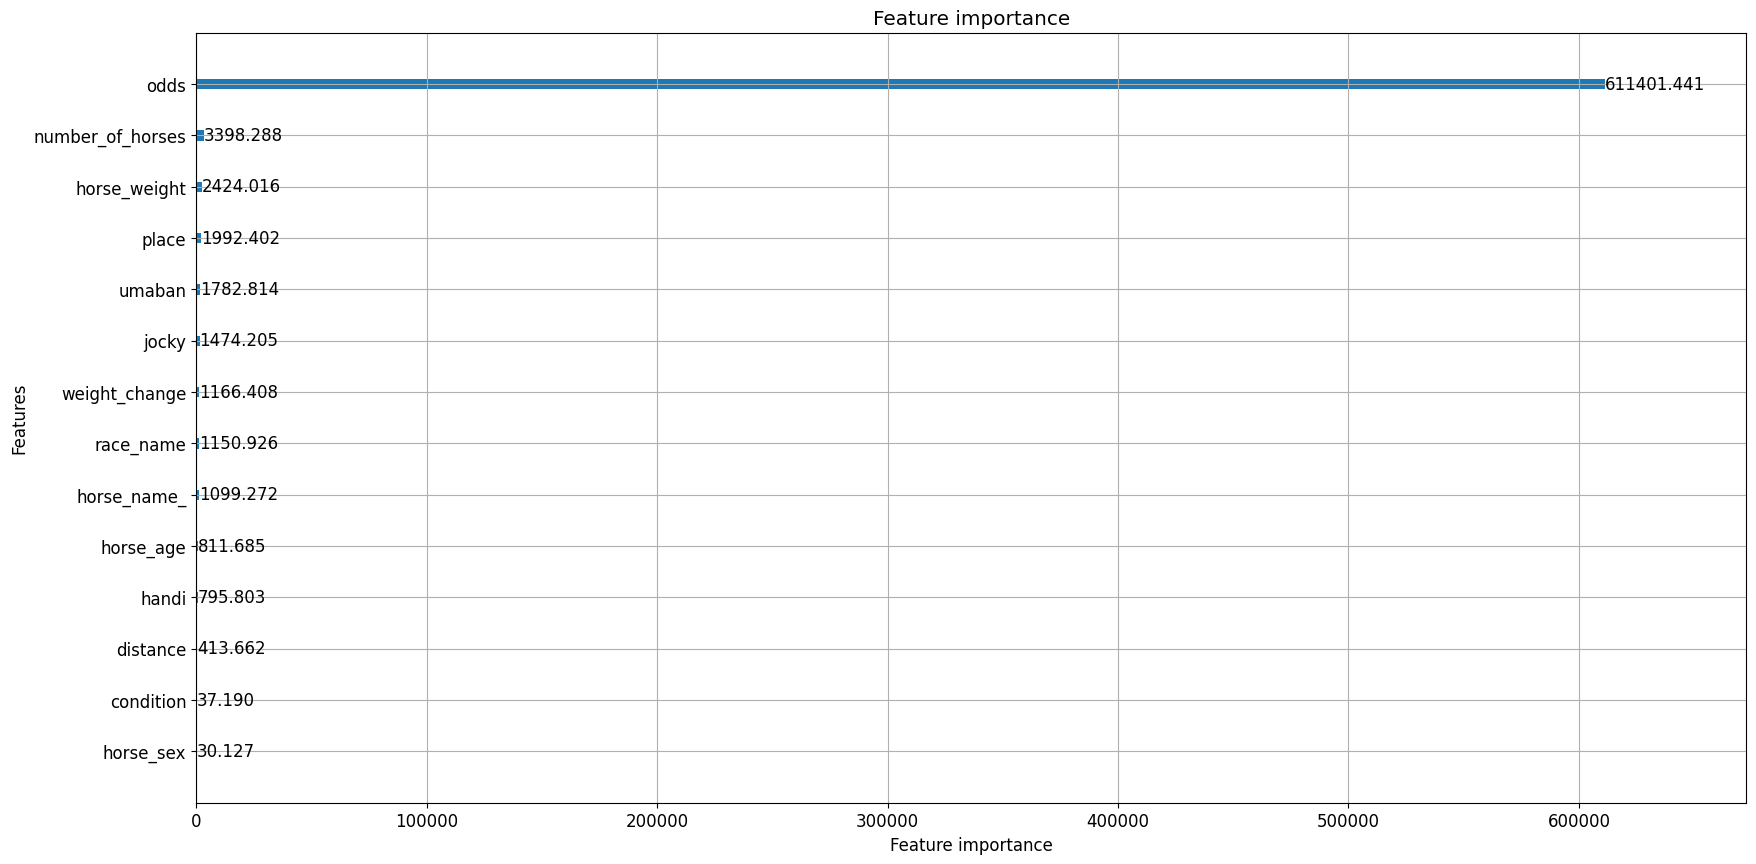

In [26]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7902857142857143


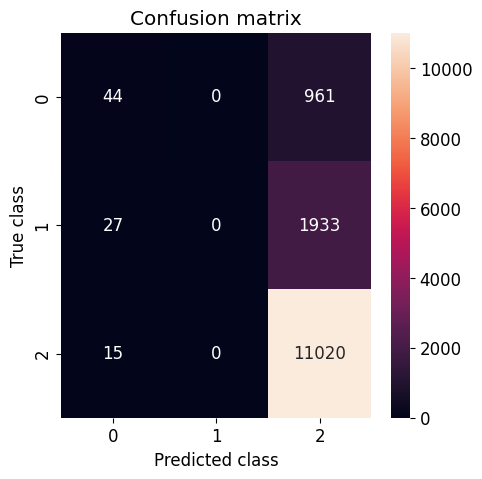

In [27]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7902857142857143


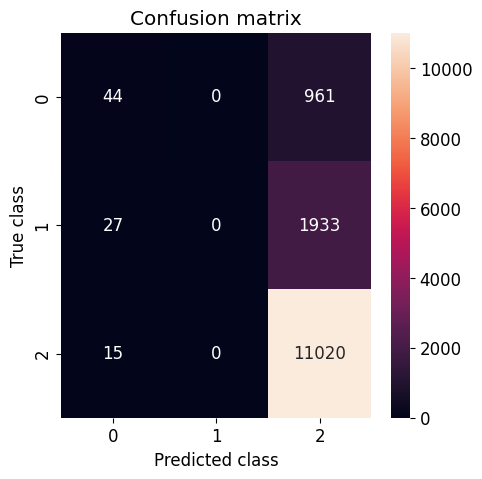

In [28]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       0.57      0.05      0.09      2180
           1       0.00      0.00      0.00      4350
           2       0.79      1.00      0.88     23470

    accuracy                           0.79     30000
   macro avg       0.45      0.35      0.32     30000
weighted avg       0.66      0.79      0.70     30000



/home/hayato/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hayato/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hayato/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


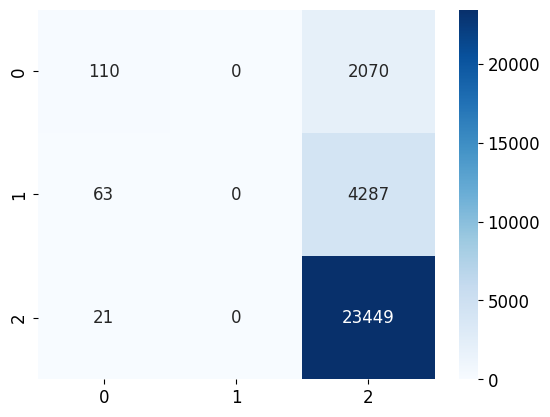

In [29]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [30]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

def create_query(df, name='train'):
    # データの先頭を表示して確認
    # print("DataFrame head:")
    # print(df.head())

    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    print(df[['date', 'race_name', 'place', 'number_of_horses', 'distance',"target_no1_umaban"]].drop_duplicates().head())

    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['date', 'race_name', 'place', 'number_of_horses', 'distance',"target_no1_umaban"]).size().reset_index(name='horse_count')

    # date列を昇順にソート
    # race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の古い順にソート
    sorted_df = df.set_index(['date', 'race_name', 'place', 'number_of_horses', 'distance',"target_no1_umaban"]).sort_index(level='date', ascending=True).reset_index()

    # ソートデータの保存
    # sorted_df.to_csv("sorted_{}_data.csv".format(name), index=False)
    return horse_counts_list, sorted_df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Unique combinations of date, race_name, place, number_of_horses, distance:
    date race_name     place  number_of_horses  distance  target_no1_umaban
0    253     2歳未勝利  ,1回札幌1日目                10      1500                  5
10   253     3歳未勝利  ,1回札幌1日目                12      1000                  4
22   253     3歳未勝利  ,1回札幌1日目                13      1700                 13
35   253      2歳新馬  ,1回札幌1日目                13      1200                  3
48   253     3歳未勝利  ,1回札幌1日目                16      2000                 12

Resulting list of horse counts per race (sorted by date):
[8, 7, 15, 13, 10, 16, 16, 16, 16, 16, 16, 11, 12, 15, 16, 16, 16, 16, 13, 16, 14, 11, 16, 15, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 14, 9, 13, 16, 15, 16, 16, 14, 15, 15, 15, 16, 16, 16, 15, 16, 16, 13, 14, 16, 16, 16, 15, 16, 10, 11, 16, 16, 12, 16, 14, 14, 16, 12, 16, 16, 16, 16, 13, 16, 16, 16, 12, 16, 15, 16, 16, 16, 11, 14, 9, 13, 14, 16, 11, 15, 11, 15, 15, 16, 16, 10, 

In [31]:
# クエリの数の合計とデータ数が一致しているか確認
print("Number of queries in train data: {}".format(len(train_query)))
print("Number of queries in valid data: {}".format(len(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 3511
Number of queries in valid data: 1075
Total number of queries: 4586
Number of rows in train data: 49000
Number of rows in valid data: 14700
Total number of rows: 63700


In [32]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

In [33]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [34]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [35]:
# # goal numberをスコア化
# # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([1], 30)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([2], 28)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([3], 26)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)

In [36]:
# # goal numberをスコア化
# # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([1], 30)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([2], 28)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([3], 26)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)

In [37]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


In [38]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_name         49000 non-null  int64  
 1   place             49000 non-null  int64  
 2   number_of_horses  49000 non-null  int64  
 3   distance          49000 non-null  int64  
 4   condition         49000 non-null  int64  
 5   horse_name_       49000 non-null  int64  
 6   umaban            49000 non-null  int64  
 7   horse_age         49000 non-null  int64  
 8   horse_sex         49000 non-null  int64  
 9   horse_weight      49000 non-null  int64  
 10  weight_change     49000 non-null  int64  
 11  handi             49000 non-null  float64
 12  jocky             49000 non-null  int64  
 13  odds              49000 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 5.2 MB


In [39]:
# 検証データ
X_sorted_valid_data.describe()

,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds
count,14700.000000,14700.000000,14700.000000,14700.000000,14700.00000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000
mean,55.058231,44.673878,14.205850,1623.624490,0.57551,2789.507687,7.604082,3.580408,0.411429,467.054354,0.152585,55.123333,111.671769,68.913633
std,89.279711,26.108242,2.522328,458.346716,0.57567,1601.494706,4.342235,1.330688,0.549334,39.027871,6.730083,1.781329,55.468604,100.419558
min,0.000000,0.000000,5.000000,1000.000000,0.00000,0.000000,1.000000,2.000000,0.000000,-22.000000,-34.000000,48.000000,0.000000,1.000000
25%,6.000000,22.000000,12.000000,1200.000000,0.00000,1398.000000,4.000000,3.000000,0.000000,448.000000,-4.000000,54.000000,68.000000,8.600000
50%,8.000000,44.000000,15.000000,1600.000000,1.00000,2772.500000,7.000000,3.000000,0.000000,468.000000,0.000000,55.000000,115.000000,26.600000
75%,63.000000,67.000000,16.000000,1800.000000,1.00000,4211.250000,11.000000,4.000000,1.000000,488.000000,4.000000,56.000000,164.000000,86.600000
max,300.000000,89.000000,18.000000,3930.000000,2.00000,5555.000000,18.000000,11.000000,2.000000,570.000000,48.000000,64.000000,207.000000,922.300000


In [40]:
# 学習データの答え
print(y_train_ranking.head())
y_train_ranking.describe()

0    30
1    26
2     0
3     0
4     0
Name: goal_number_replace, dtype: int64


count    49000.000000
mean         6.029143
std         11.534399
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: goal_number_replace, dtype: float64

In [41]:
print(y_train_ranking_goal.head())
y_train_ranking_goal.describe()

0    1
1    3
2    4
3    8
4    5
Name: goal_number, dtype: int64


count    49000.000000
mean         7.704694
std          4.371639
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         18.000000
Name: goal_number, dtype: float64

In [42]:
# 検証データの答え
print(y_valid_ranking.head())
y_valid_ranking.describe()

0    28
1     0
2     0
3    30
4     0
Name: goal_number_replace, dtype: int64


count    14700.000000
mean         6.138912
std         11.610056
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: goal_number_replace, dtype: float64

In [43]:
# テストデータ
test_ranking.describe()

,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,100.182567,88.916767,14.579100,1629.280333,0.540200,4747.086567,7.789800,3.676033,0.413200,468.930833,-0.035500,55.159483,134.582767,71.245257
std,172.975761,51.729402,2.266035,463.498277,0.572999,2726.431278,4.397756,1.350138,0.552578,38.045879,6.807123,1.788229,63.866769,103.623633
min,0.000000,0.000000,6.000000,1000.000000,0.000000,0.000000,1.000000,2.000000,0.000000,-22.000000,-46.000000,48.000000,0.000000,1.100000
25%,6.000000,44.000000,13.000000,1200.000000,0.000000,2371.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,80.000000,8.700000
50%,8.000000,90.000000,15.000000,1700.000000,1.000000,4777.000000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,137.000000,27.300000
75%,108.000000,134.000000,16.000000,1800.000000,1.000000,7133.250000,11.000000,4.000000,1.000000,490.000000,4.000000,56.000000,193.000000,87.900000
max,580.000000,177.000000,18.000000,4250.000000,2.000000,9487.000000,18.000000,12.000000,2.000000,608.000000,50.000000,63.500000,245.000000,999.900000


In [44]:
# テストデータの答え
print(y_test_true_ranking.head())
y_test_true_ranking.describe()

70000     0
70001     0
70002     0
70003     0
70004    26
Name: goal_number_replace, dtype: int64


count    30000.000000
mean         5.934067
std         11.467713
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: goal_number_replace, dtype: float64

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ハイパーパラメータのグリッドを定義
param_grid = {
    'n_estimators': [1000, 5000, 10000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [3,5,12, 31, 50],
    'max_depth': [3,6, 8, 10],
    'min_data_in_leaf': [5,10, 20, 30]
}

# カスタムスコア関数を定義
def ndcg_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return ndcg_score([y], [y_pred], k=5)

# 交差検証の設定
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCVを使用してハイパーパラメータチューニング
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=ndcg_scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query
)
# 最適なパラメータを出力
print("Best parameters found: ", grid_search.best_params_)

# 最適なモデルで再トレーニング
best_model = grid_search.best_estimator_

best_model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 3, 5],
    eval_metric='ndcg',
    early_stopping_rounds=100
)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


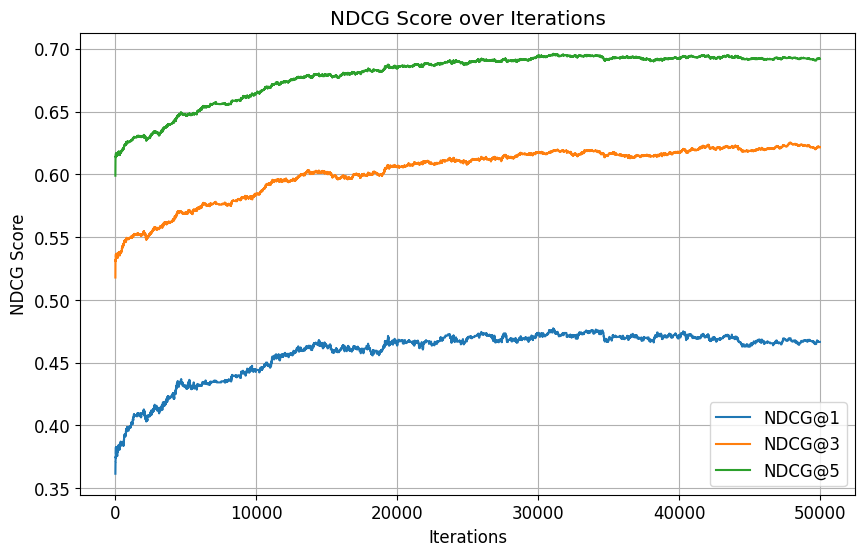

In [45]:
# トレーニング結果の取得
evals_result = best_model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#　テストデータで推論

prediction_test_ranking = best_model.predict(test_ranking, num_iteration=best_model.best_iteration_)

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア": prediction_test_ranking,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
})
print(df_prediction_test_ranking)
# pandasをcsvに保存
inference_data_path_result = inference_data_path + "inference_result/"
if not os.path.isdir(inference_data_path_result):
    os.mkdir(inference_data_path_result)
df_prediction_test_ranking.to_csv(inference_data_path_result + "prediction_test_ranking.csv", index=False)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
       馬番号     予測スコア  着順関連度  着順
70000    8 -7.494930      0  10
70001    9 -0.150686      0   4
70002   10 -1.493907      0   5
70003   11 -4.113807      0  12
70004   12 -0.523346     26   3
...    ...       ...    ...  ..
99995    6  0.217828      0   7
99996    7  0.145389      0   5
99997    8 -2.786646      0   6
99998    9  0.114440     26   3
99999   10 -5.079445      0   8

[30000 rows x 4 columns]


In [47]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": best_model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

             columns  importance
13              odds       83611
5        horse_name_       70800
1              place       70664
12             jocky       59655
9       horse_weight       59447
6             umaban       38667
0          race_name       37718
10     weight_change       35327
3           distance       26328
2   number_of_horses       24866
11             handi       19643
7          horse_age       11825
8          horse_sex        5977
4          condition        5472


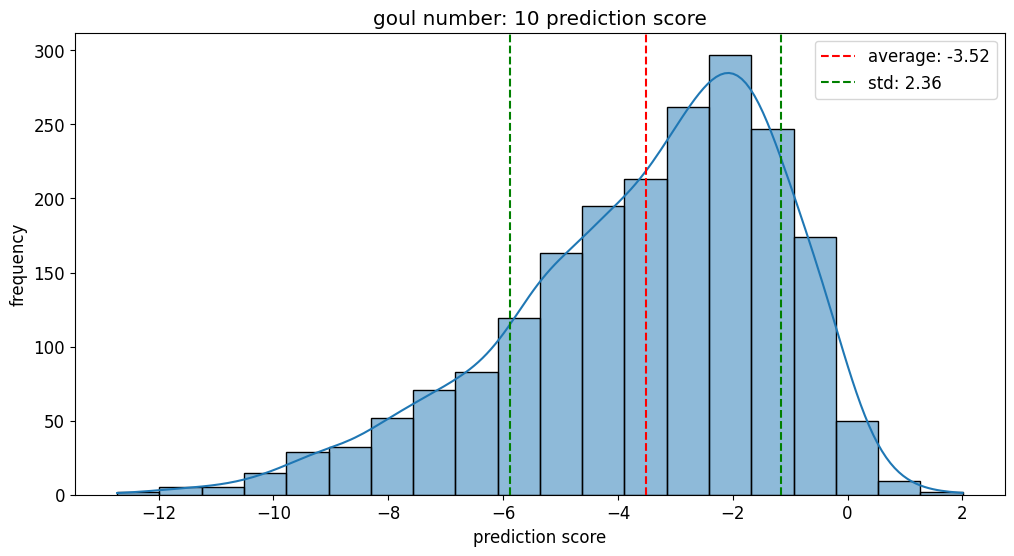

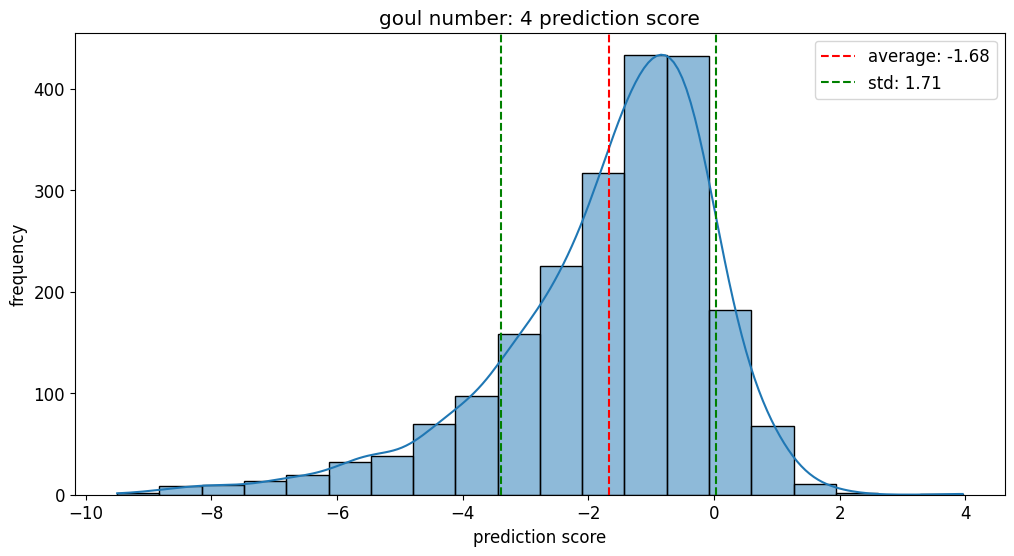

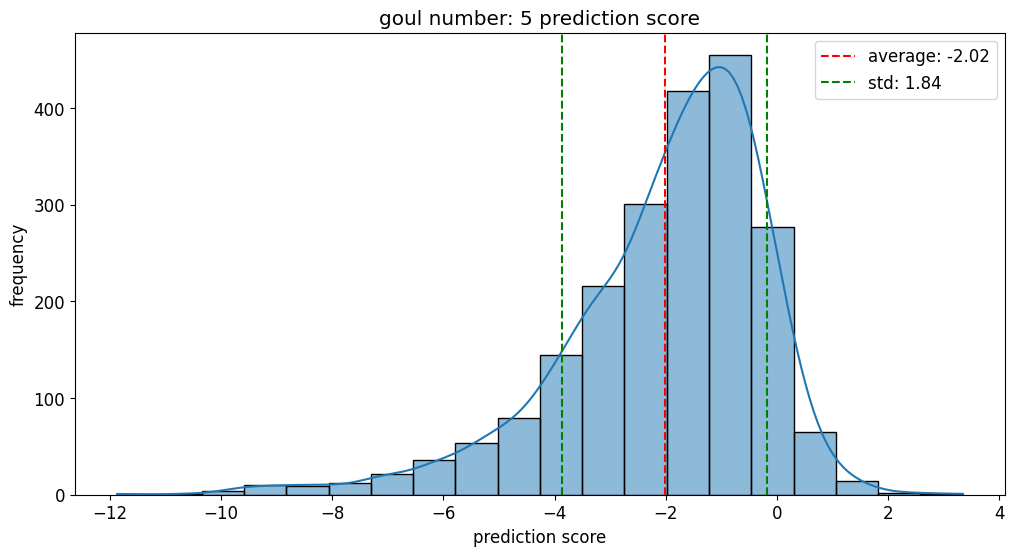

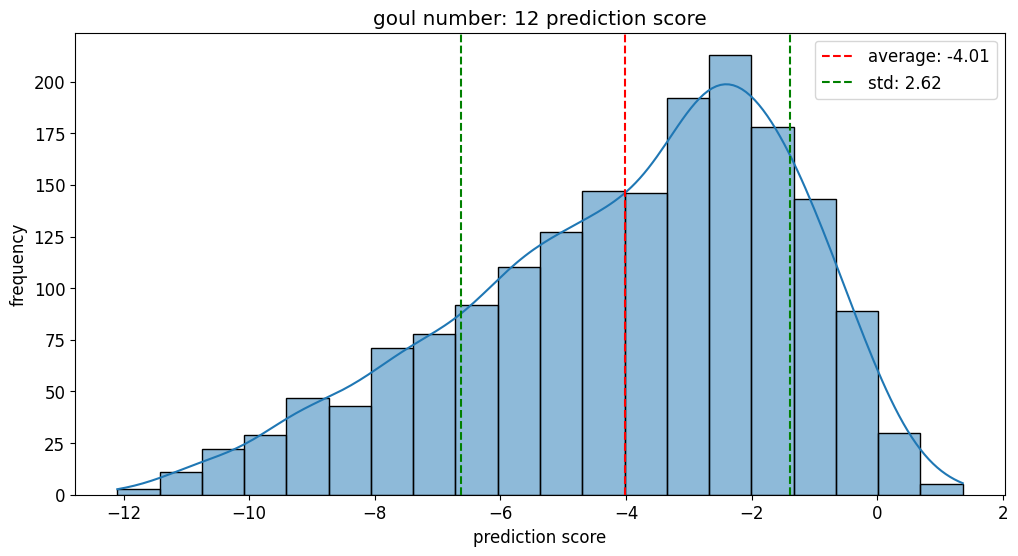

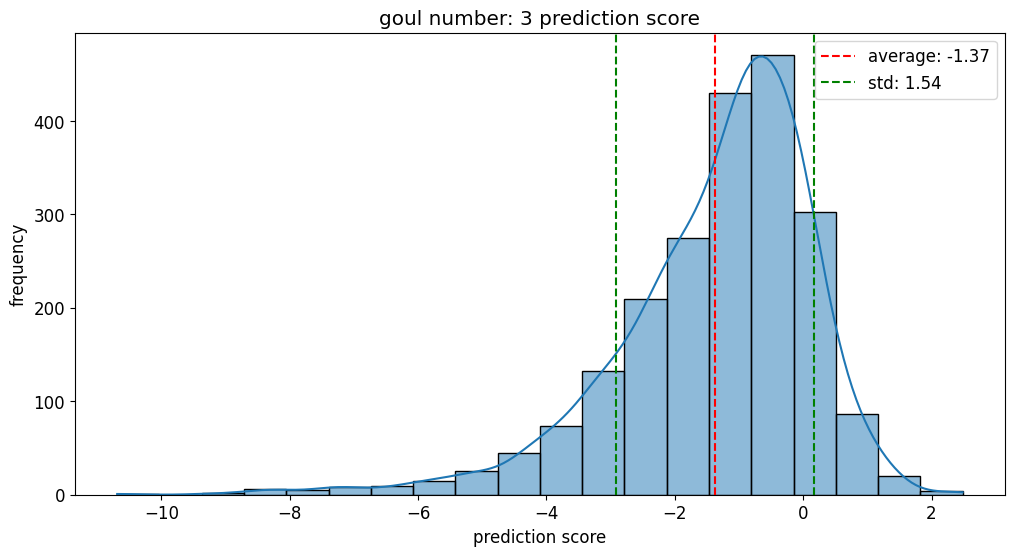

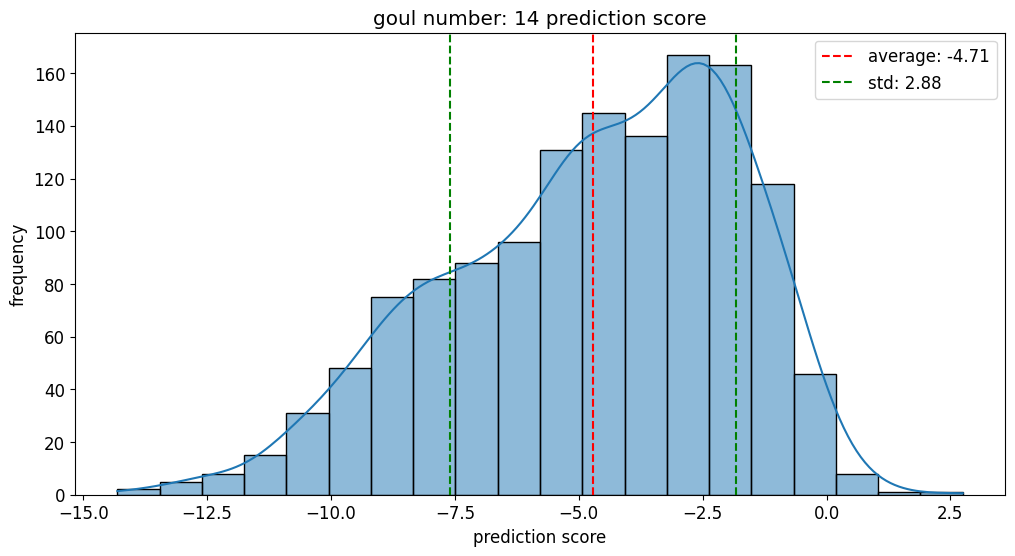

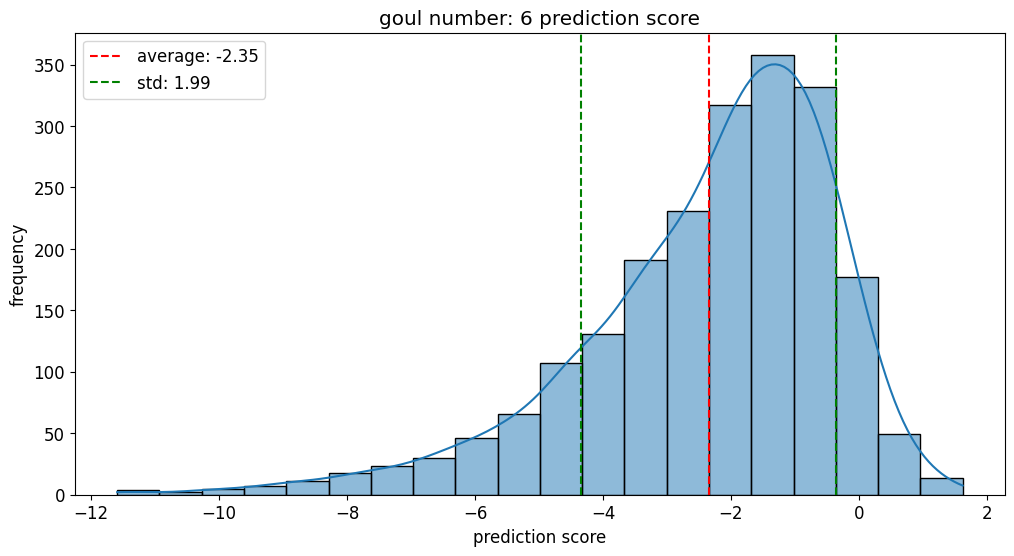

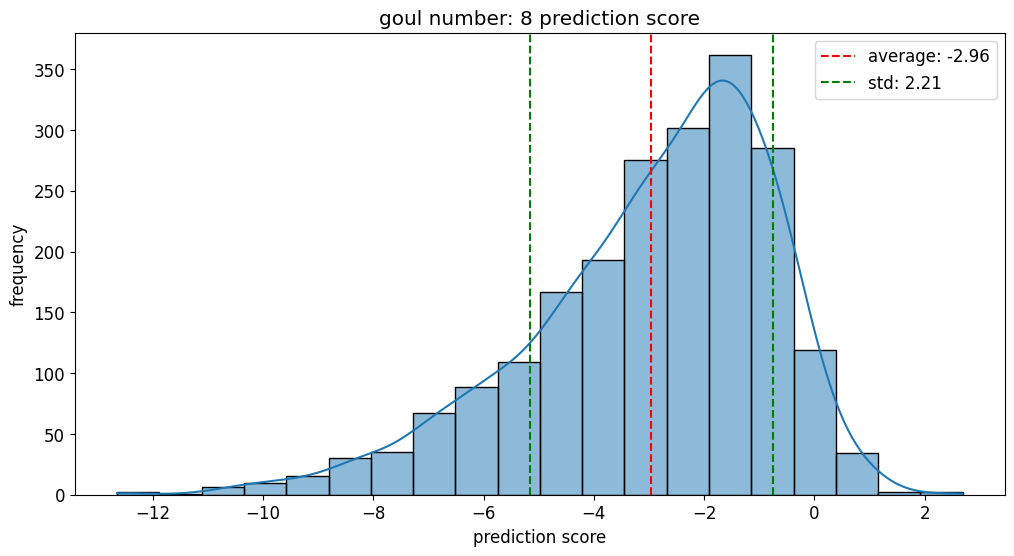

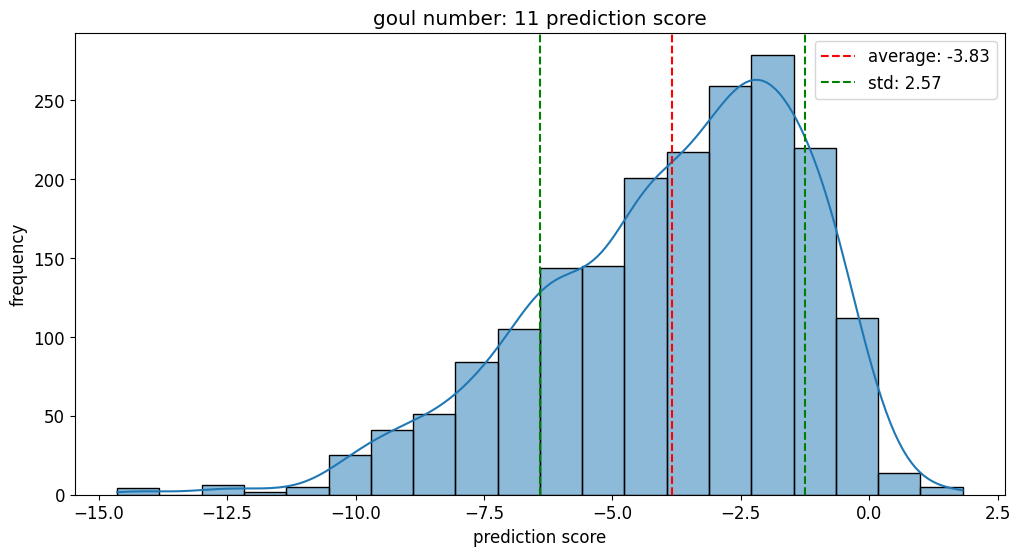

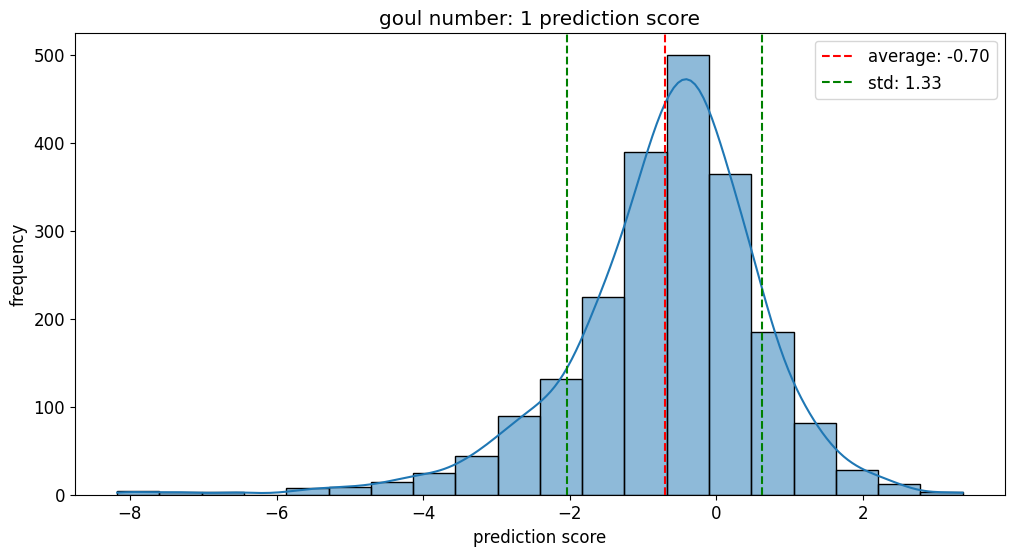

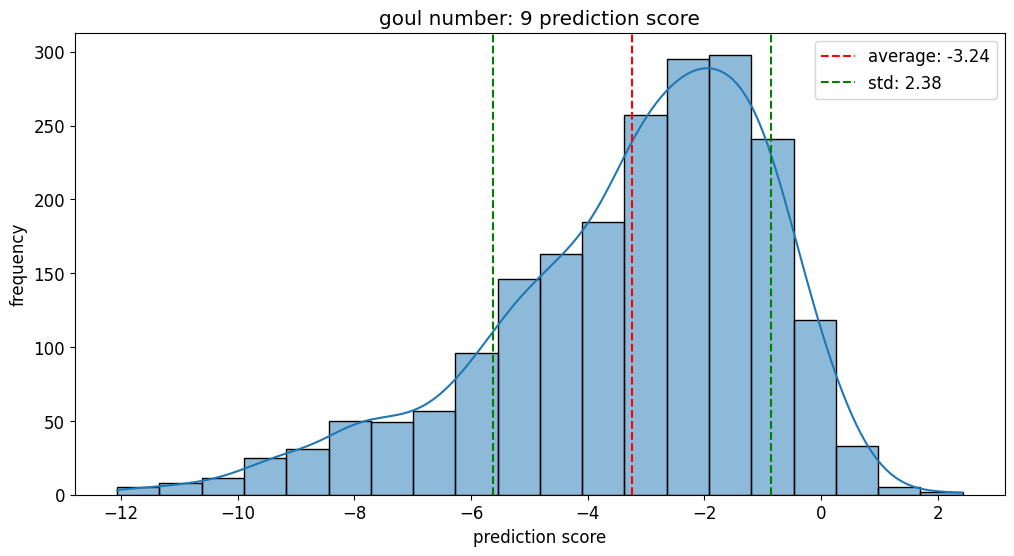

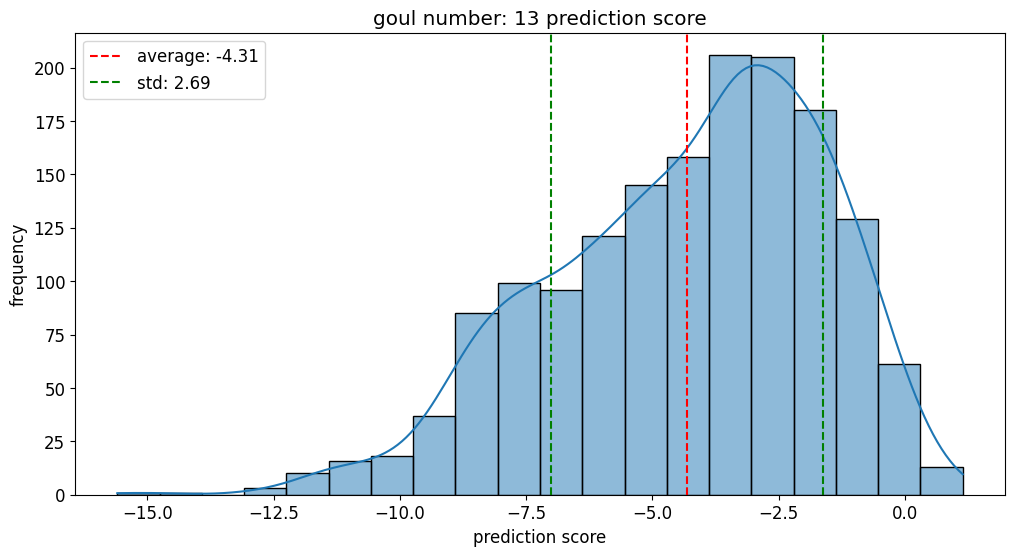

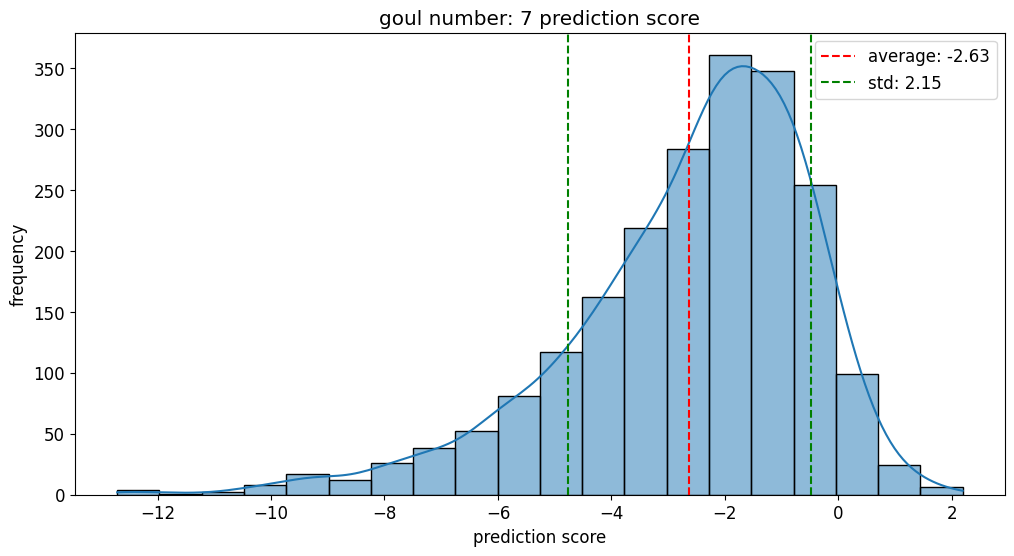

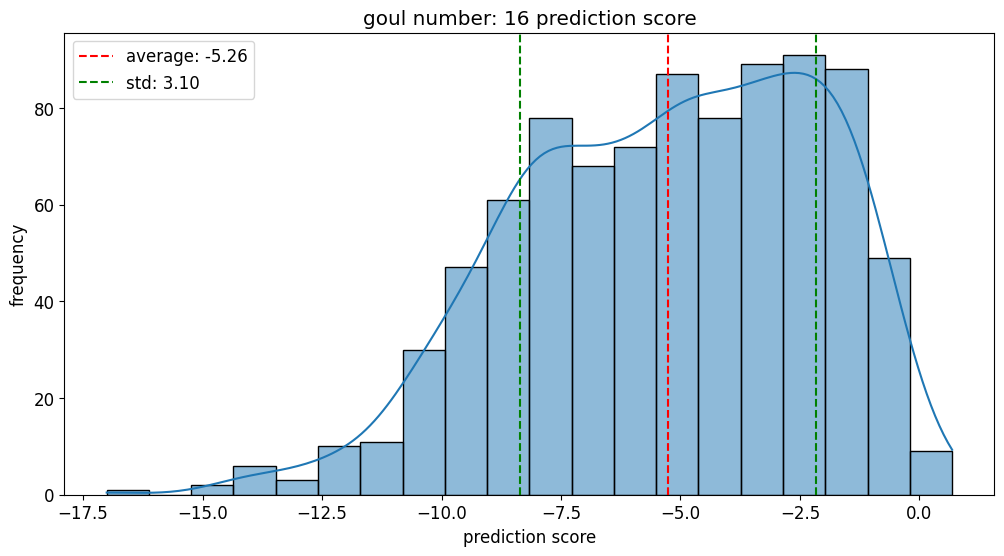

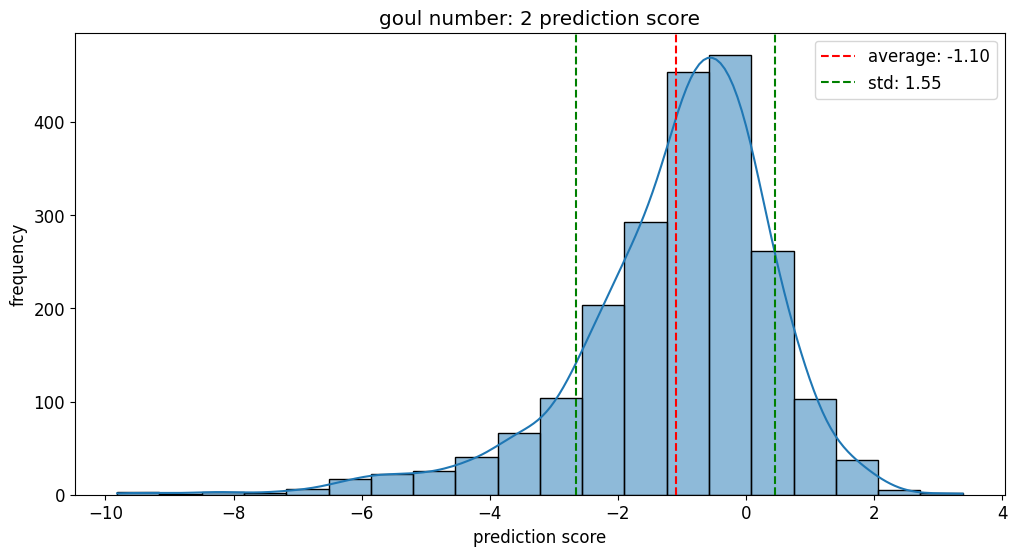

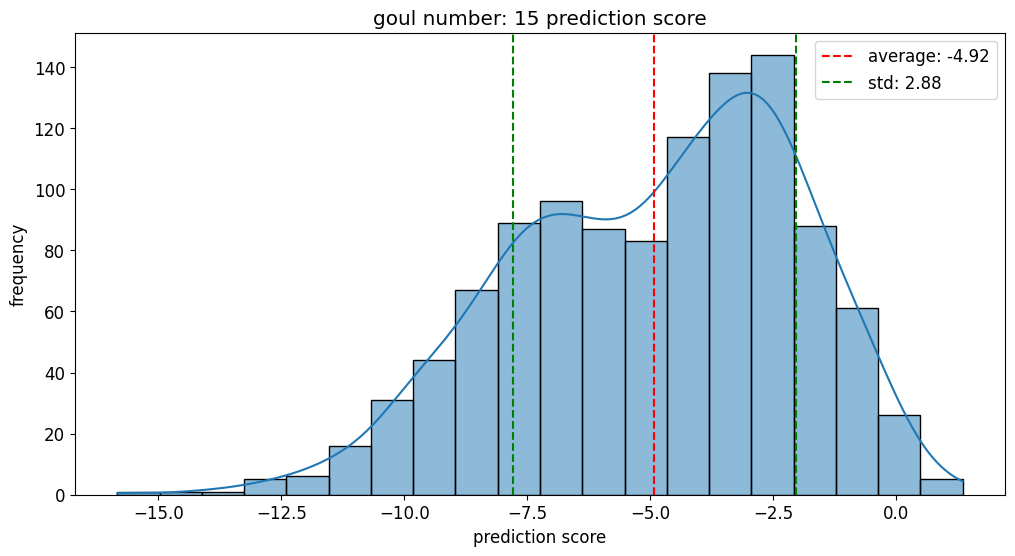

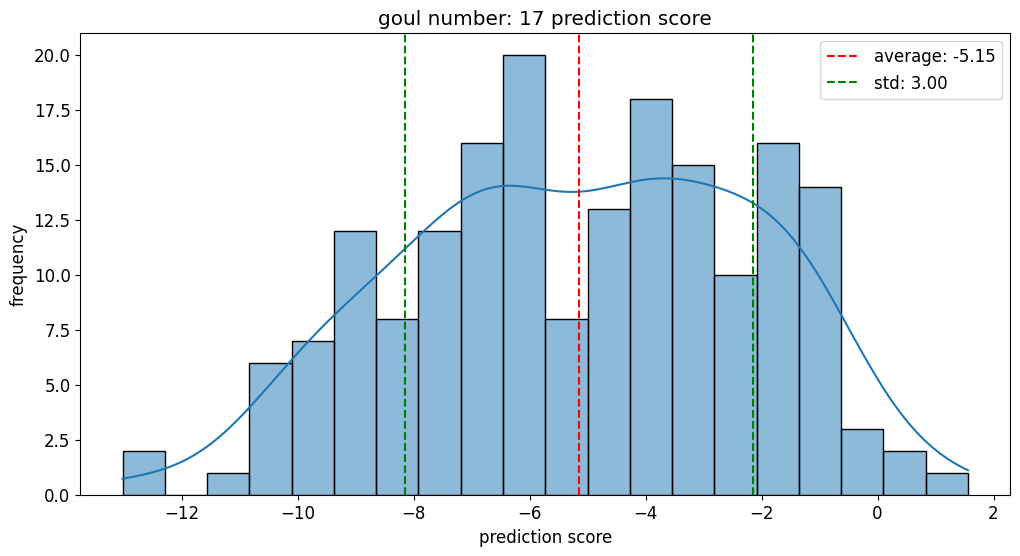

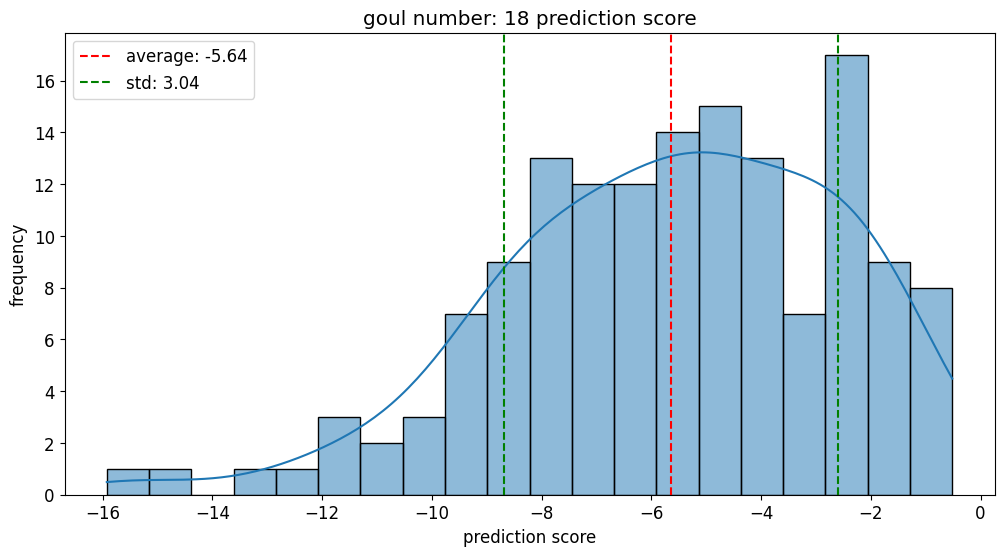

In [48]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# # 日本語フォントの設定
# font_path = '/usr/share/fonts/truetype/ipafont-gothic/ipagp.ttf'  # フォントのパス
# font_prop = fm.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = font_prop.get_name()

grouped = df_prediction_test_ranking.groupby("着順")["予測スコア"].agg(['mean', 'std']).reset_index()
unique_ranks = df_prediction_test_ranking["着順"].unique()

for rank in unique_ranks:
    plt.figure(figsize=(12, 6))
    subset = df_prediction_test_ranking[df_prediction_test_ranking["着順"] == rank]
    mean_score = subset["予測スコア"].mean()
    std_score = subset["予測スコア"].std()
    
    sns.histplot(subset["予測スコア"], bins=20, kde=True)
    plt.axvline(mean_score, color='r', linestyle='--', label=f'average: {mean_score:.2f}')
    plt.axvline(mean_score + std_score, color='g', linestyle='--', label=f'std: {std_score:.2f}')
    plt.axvline(mean_score - std_score, color='g', linestyle='--')
    
    plt.title(f"goul number: {rank} prediction score")
    plt.xlabel("prediction score")
    plt.ylabel("frequency")
    plt.legend()
    plt.show()

In [49]:
from pathlib import Path
import pandas as pd
import tqdm

# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("inference*.csv"))
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    print("=======予測ファイル名======== {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する

    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        inference_data[column] = le.fit_transform(inference_data[column])

    # Unnamed: 0,class_list_in_raceを削除
    inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()

    #　=================real dataで推論=============================
    inference_data_answer = inference_data["goal_number"]
    inference_data = inference_data.drop("goal_number", axis=1)

    prediction_inference_ranking = best_model.predict(inference_data, num_iteration=best_model.best_iteration_)
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "馬番号": inference_data["umaban"],
        "予測スコア": prediction_inference_ranking,
        "odds": inference_data["odds"],
        "着順": inference_data_answer,
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア", ascending=False)

    # 予測順位を計算
    df_prediction_test_ranking["予測順位"] = df_prediction_test_ranking["予測スコア"].rank(ascending=False, method='first').astype(int)

    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)
    count = 0
    df_prediction_test_ranking.to_csv(inference_data_path_result + "prediction_real_data_inference_ranking_" +  str(count) + "_.csv", index=False)
    count +=1
    print(df_prediction_test_ranking)

100%|██████████| 7/7 [00:00<00:00, 44.52it/s]

=======予測ファイル名======== /home/hayato/horse_inference/inference/2024060508/add_dynamic_data/inference_data_202406050811.csv
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
    馬番号     予測スコア  着順  予測順位
0     6 -0.628846  14     1
1     5 -0.947114   7     2
2     7 -1.146883   1     3
3     3 -1.221555  12     4
4     8 -1.222133  13     5
5     4 -1.472400   4     6
6    10 -1.763086   5     7
7     2 -2.127557   6     8
8    13 -2.180460   9     9
9    12 -2.365097   8    10
10    9 -2.591966  11    11
11   14 -2.687918  15    12
12    1 -2.774743   3    13
13   11 -3.087073  10    14
14   15 -4.071349   2    15
=======予測ファイル名======== /home/hayato/horse_inference/inference/2024060508/add_dynamic_data/inference_data_20240605087.csv
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
    馬番号     予測スコア  着順  予測順位
0     3  0.046195   6     1
1     9 -

In [50]:
# やること
# 特長量前処理
# 特徴量追加
# ハイパラチューニング-> 完了
# 馬ID、ジョッキーIDを取得し、別csvで紐づけ